<a href="https://colab.research.google.com/github/ziishanahmad/ai-detect-closed-eyes-while-driving/blob/main/ai_detect_closed_eyes_while_driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install opencv-python-headless tensorflow transformers


In [ ]:
import zipfile
import os

# Path to the uploaded dataset zip file
zip_file_path = 'eyeopenclose.zip'
extract_path = 'eyeopenclose-dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Extracted to {extract_path}')

# List the extracted files and directories
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print('{}{}/'.format(indent, os.path.basename(root)))
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print('{}{}'.format(subindent, f))


Found 2720 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Epoch 1/10
85/85 [==============================] - 9s 22ms/step - loss: 0.3710 - accuracy: 0.8276 - val_loss: 0.4602 - val_accuracy: 0.8676
Epoch 2/10
85/85 [==============================] - 2s 19ms/step - loss: 0.1153 - accuracy: 0.9658 - val_loss: 0.3737 - val_accuracy: 0.9382
Epoch 3/10
85/85 [==============================] - 2s 19ms/step - loss: 0.0613 - accuracy: 0.9842 - val_loss: 0.5620 - val_accuracy: 0.9162
Epoch 4/10
85/85 [==============================] - 2s 18ms/step - loss: 0.0458 - accuracy: 0.9882 - val_loss: 0.5123 - val_accuracy: 0.9368
Epoch 5/10
85/85 [==============================] - 2s 19ms/step - loss: 0.0312 - accuracy: 0.9908 - val_loss: 0.5121 - val_accuracy: 0.9382
Epoch 6/10
85/85 [==============================] - 2s 27ms/step - loss: 0.0261 - accuracy: 0.9912 - val_loss: 0.5970 - val_accuracy: 0.9294
Epoch 7/10
85/85 [==============================] - 2s 19ms/step - loss

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 214ms/step


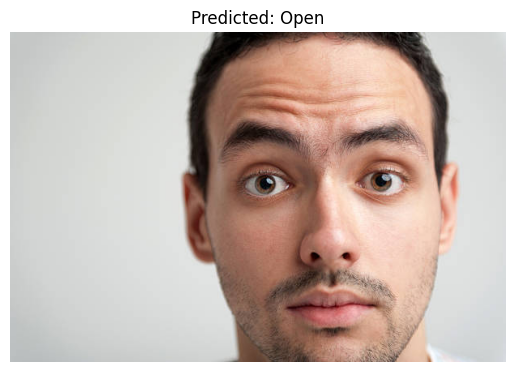

1/1 [==============================] - 0s 16ms/step


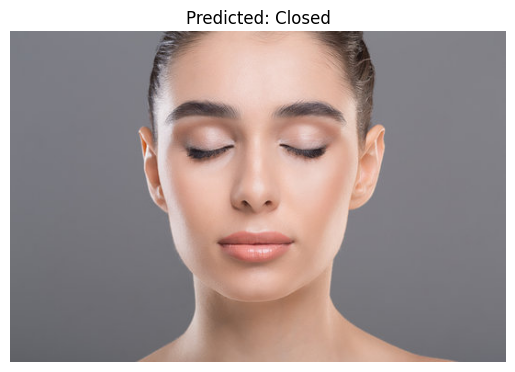

In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the dataset
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'eyeopenclose-dataset/dataset/train',
    target_size=(24, 24),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'eyeopenclose-dataset/dataset/train',
    target_size=(24, 24),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    subset='validation')

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(24, 24, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Save the model
model.save('open_closed_eye_model.h5')

# Load the model
model = load_model('open_closed_eye_model.h5')

# Function to preprocess the test image
def preprocess_test_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (24, 24))  # Resize to the input size of the model
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# Test the model with sample images
test_image_paths = [
    'eyes-open.jpg',
    'eyes-closed.jpg'
]

for image_path in test_image_paths:
    img = preprocess_test_image(image_path)
    prediction = model.predict(img)
    state = 'Open' if prediction[0] > 0.5 else 'Closed'

    # Load and display the image with prediction
    img_display = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {state}')
    plt.axis('off')
    plt.show()
